### The notebook contains a flag called "skip = True" that skips the training process by loading a pre compiled model from storage. This was to elevate the reader from executing a long training job (15min). 

### LSTM - Feature columns: All Features || Prediction: Pickup count by Zone

#### Prediction displays poor performance

In [101]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# FIX ME: Root dir as argument
root_dir = "../../data/picklerCheckpoints/"
is_compressed = True;
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
skip = True

In [35]:
import numpy as np
import pandas as pd
import nbimporter
import geopandas as gpd
import commons.utility.pickle_util as pickle
import Preprocessing.SpatialMapping as sm
import Preprocessing.Discretization as dis
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import tensorflow as tf

coord_system = {'init': 'epsg:4326'}

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot

In [37]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
import keras
from keras import layers

In [38]:
data = sm.run(['apr', 'may', 'jun', 'jul', 'aug'])

Data for the month :apr Found.....
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loading file ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-apr14.p
Decompressing ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-apr14.p.pbz2..............Done
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Data for the month :may Found.....
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loading file ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-may14.p
Decompressing ../data/picklerCheckpoints/spatialJoinData/uber-spatial-data-may14.p.pbz2..............Done
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Data for the month :jun Found.....
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loading file

In [75]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [76]:
def ljust(lst, n, fillvalue=0):
    return lst + [fillvalue] * (n - len(lst))

In [77]:
def transposeZones(df2, column):
    dftest = df2[['datetime', column, 'pickups']]
    dftest = dftest.sort_values(['datetime', column], ascending=[True, True]).set_index('datetime')
    #dftest.head(len(dftest.zone.unique())-1)
    zone_order = dftest[column].unique()
#     print(zone_order)
    dftest = dftest.groupby('datetime').agg({lambda x: x.tolist()})
    a = dftest.loc[:, ['pickups']].T
    b = dftest.loc[:, [column]].T
    N = len(zone_order)
    M = np.shape(a)[1]
    acc = []
    idx = 0
    for date in a.columns:
        sub_list_start = 0
        sub_list_end = len(a[date])
        row = a[date].values[0]
        acc.append(ljust(row, N))
       # zeros[idx][sub_list_start : sub_list_end+1] = a[date]
        idx = idx + 1
#     print(acc[0])
    zoneDf = pd.DataFrame(acc, columns=zone_order)
    df3 = df2[['datetime', 'dayOfWeek', 'hourOfDay', 'humidity', 'pressure', 'temperature', 'windDirection', 'holiday', 'windSpeed']].drop_duplicates().reset_index()
    return pd.merge(df3, zoneDf, left_index=True, right_index=True).drop(['index', 'datetime'], 1)

In [102]:
df = data.copy()

In [103]:
df2 = df[['datetime', 'zone', 'weatherCondition', 'humidity', 'pressure', 'temperature', 'windDirection', 'windSpeed', 'holiday']]

In [104]:
df2 = dis.encode(df2, ['holiday', 'weatherCondition', 'zone'])

D:\Academics\MLRepoFeb\ML2020-Uber-Data-Analysis\Preprocessing\Discretization.ipynb:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "metadata": {},


Result Saved in ../data/encodedMappings/holiday.p
Result Saved in ../data/encodedMappings/weatherCondition.p
Result Saved in ../data/encodedMappings/zone.p


In [105]:
df2['dayOfWeek'] = pd.to_datetime(df2['datetime'], format='%m-%d-%Y:%H')
df2['hourOfDay'] =  pd.to_datetime(df2['datetime'], format='%m-%d-%Y:%H')
df2['dayOfWeek'] = df2['dayOfWeek'].dt.day_name()
df2['hourOfDay'] = df2['hourOfDay'].dt.hour

<ipython-input-105-9ac9e5788ff7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['dayOfWeek'] = pd.to_datetime(df2['datetime'], format='%m-%d-%Y:%H')
<ipython-input-105-9ac9e5788ff7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['hourOfDay'] =  pd.to_datetime(df2['datetime'], format='%m-%d-%Y:%H')
<ipython-input-105-9ac9e5788ff7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [106]:
week_dict = {
    "Sunday": 1,
    "Monday": 2,
    "Tuesday": 3,
    "Wednesday":4,
    "Thursday":5,
    "Friday": 6,
    "Saturday": 7
}

In [107]:
df2['dayOfWeek'] = df2.dayOfWeek.apply(lambda x: week_dict[x])

<ipython-input-107-35d0f5211b87>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['dayOfWeek'] = df2.dayOfWeek.apply(lambda x: week_dict[x])


In [108]:
# data

In [109]:
# cols_to_norm = ['humidity','pressure', 'temperature', 'windDirection', 'windSpeed']
# df2[cols_to_norm] = df2[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [110]:
feature_cols = ['datetime', 'zone', 'dayOfWeek', 'hourOfDay', 'humidity','pressure', 'temperature', 'windDirection', 'holiday', 'windSpeed']
df2 = df2[feature_cols]
N = len(df2['zone'].unique())

In [111]:
df2 = df2.groupby(feature_cols).size().reset_index(name='pickups')

In [112]:
# pickups = df2['pickups']
# pickups.pop(0)
# pickups.reset_index(inplace=True, drop=True)
# df2.drop(df2.tail(1).index,inplace=True)

In [113]:
# df2['Pickups_t-1h'] = pickups 
# df2['zone'] = df2['borough']

In [114]:
df2 = transposeZones(df2, 'zone')

In [115]:
df2

,dayOfWeek,hourOfDay,humidity,pressure,temperature,windDirection,holiday,windSpeed,10,11,...,80,239,95,43,24,2,198,41,27,99
0,3,0,40.0,1016.0,282.96,330.0,1,5.0,3,1,...,0,0,0,0,0,0,0,0,0,0
1,3,3,60.0,1018.0,278.07,20.0,1,6.0,2,1,...,0,0,0,0,0,0,0,0,0,0
2,3,4,60.0,1019.0,277.19,360.0,1,4.0,2,1,...,0,0,0,0,0,0,0,0,0,0
3,3,5,60.0,1019.0,276.49,340.0,1,4.0,5,5,...,0,0,0,0,0,0,0,0,0,0
4,3,6,64.0,1020.0,275.99,290.0,1,3.0,1,11,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3629,1,19,46.0,1016.0,303.45,230.0,2,7.0,13,18,...,0,0,0,0,0,0,0,0,0,0
3630,1,20,46.0,1015.0,302.18,220.0,2,6.0,1,17,...,0,0,0,0,0,0,0,0,0,0
3631,1,21,88.0,1016.0,299.70,240.0,2,6.0,1,15,...,0,0,0,0,0,0,0,0,0,0
3632,1,22,94.0,1015.0,298.71,0.0,2,1.0,1,25,...,0,0,0,0,0,0,0,0,0,0


In [116]:
# feature_cols = ['datetime', 'zone', 'dayOfWeek', 'hourOfDay', 'humidity','pressure', 'temperature', 'windDirection', 'windSpeed', 'Pickups_t-1h', 'pickups']
# df2 = df2[feature_cols]

In [117]:
values = df2.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [118]:
reframed = series_to_supervised(scaled, 7, N)

In [119]:
listOfDrops = []
for i in range(7*len(df2.columns),len(reframed.columns)):
    listOfDrops.append(i)

# print("list of drops ", listOfDrops)
reframed.drop(reframed.columns[listOfDrops], axis=1, inplace=True)

In [120]:
values = reframed.values

In [121]:
df2

,dayOfWeek,hourOfDay,humidity,pressure,temperature,windDirection,holiday,windSpeed,10,11,...,80,239,95,43,24,2,198,41,27,99
0,3,0,40.0,1016.0,282.96,330.0,1,5.0,3,1,...,0,0,0,0,0,0,0,0,0,0
1,3,3,60.0,1018.0,278.07,20.0,1,6.0,2,1,...,0,0,0,0,0,0,0,0,0,0
2,3,4,60.0,1019.0,277.19,360.0,1,4.0,2,1,...,0,0,0,0,0,0,0,0,0,0
3,3,5,60.0,1019.0,276.49,340.0,1,4.0,5,5,...,0,0,0,0,0,0,0,0,0,0
4,3,6,64.0,1020.0,275.99,290.0,1,3.0,1,11,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3629,1,19,46.0,1016.0,303.45,230.0,2,7.0,13,18,...,0,0,0,0,0,0,0,0,0,0
3630,1,20,46.0,1015.0,302.18,220.0,2,6.0,1,17,...,0,0,0,0,0,0,0,0,0,0
3631,1,21,88.0,1016.0,299.70,240.0,2,6.0,1,15,...,0,0,0,0,0,0,0,0,0,0
3632,1,22,94.0,1015.0,298.71,0.0,2,1.0,1,25,...,0,0,0,0,0,0,0,0,0,0


In [122]:
# split into train and test sets
values = reframed.values
n_train_hours = 3000 
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-N], train[:, -N:]
test_X, test_y = test[:, :-N], test[:, -N:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(3000, 1, 1604) (3000, 258) (370, 1, 1604) (370, 258)


In [123]:
reframed

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var10(t-7),...,var257(t-1),var258(t-1),var259(t-1),var260(t-1),var261(t-1),var262(t-1),var263(t-1),var264(t-1),var265(t-1),var266(t-1)
7,0.333333,0.000000,0.333333,0.425532,0.309007,0.916667,0.5,0.416667,0.033333,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.333333,0.130435,0.555556,0.468085,0.167391,0.055556,0.5,0.500000,0.016667,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.333333,0.173913,0.555556,0.489362,0.141906,1.000000,0.5,0.333333,0.016667,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.333333,0.217391,0.555556,0.489362,0.121633,0.944444,0.5,0.333333,0.066667,0.090909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.333333,0.260870,0.600000,0.510638,0.107153,0.805556,0.5,0.250000,0.000000,0.227273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3372,0.500000,0.826087,0.422222,0.404255,0.820736,0.444444,0.5,0.250000,0.000000,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3373,0.500000,0.869565,0.355556,0.404255,0.827976,0.472222,0.5,0.333333,0.350000,0.159091,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3374,0.500000,0.913043,0.355556,0.404255,0.821315,0.472222,0.5,0.416667,0.300000,0.204545,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3375,0.500000,0.956522,0.355556,0.404255,0.798436,0.388889,0.5,0.250000,0.350000,0.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:
if skip == False:
    NumOfEpochs = 1000
    # design network
    model = Sequential()
    model.add(layers.LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(layers.Dense(N))
    model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
    # fit network
    start = time.time()
    history = model.fit(train_X, train_y, epochs=NumOfEpochs, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    end = time.time()
    model.save('../data/picklerCheckpoints/LSTM/LSTM-4-1000-ZONE/model')
    pickle.save(history.history, '../data/picklerCheckpoints/LSTM/LSTM-4-1000-ZONE/', 'history', True )
else:
    model = keras.models.load_model('../data/picklerCheckpoints/LSTM/LSTM-4-1000-ZONE/model')
    history = pickle.load('../data/picklerCheckpoints/LSTM/LSTM-4-1000-ZONE/history.p', True)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Loading file ../data/picklerCheckpoints/LSTM/LSTM-4-1000-ZONE/history.p
Decompressing ../data/picklerCheckpoints/LSTM/LSTM-4-1000-ZONE/history.p.pbz2..............Done
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



In [125]:
import datetime
plt.rcParams.update({'font.size': 14})


In [126]:
if skip == False:
    history = history.history

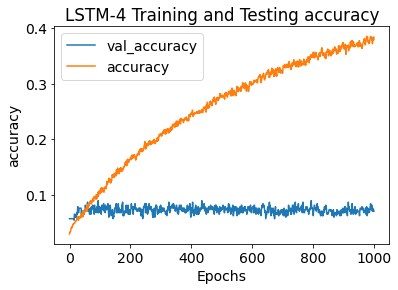

In [127]:
f = pyplot.figure()
pyplot.plot(history['val_accuracy'], label='val_accuracy')
pyplot.plot(history['accuracy'], label='accuracy')
pyplot.legend()
pyplot.xlabel('Epochs')
pyplot.ylabel('accuracy')
pyplot.title('LSTM-4 Training and Testing accuracy')
pyplot.savefig('LSTM/lstm-4-acc.png')
pyplot.show()
now = datetime.datetime.now()

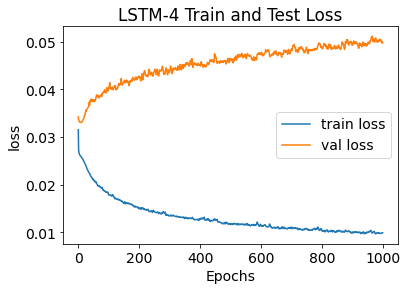

In [128]:
f1 = pyplot.figure()
pyplot.plot(history['loss'], label='train loss')
pyplot.plot(history['val_loss'], label='val loss')
pyplot.legend()
pyplot.xlabel('Epochs')
pyplot.ylabel('loss')
pyplot.title('LSTM-4 Train and Test Loss')
pyplot.savefig('LSTM/lstm-4-loss.png')
pyplot.show()
now = datetime.datetime.now()


In [129]:
end-start

-103.5053699016571

In [130]:
# make a prediction
yhat = model.predict(test_X)

(370, 266)


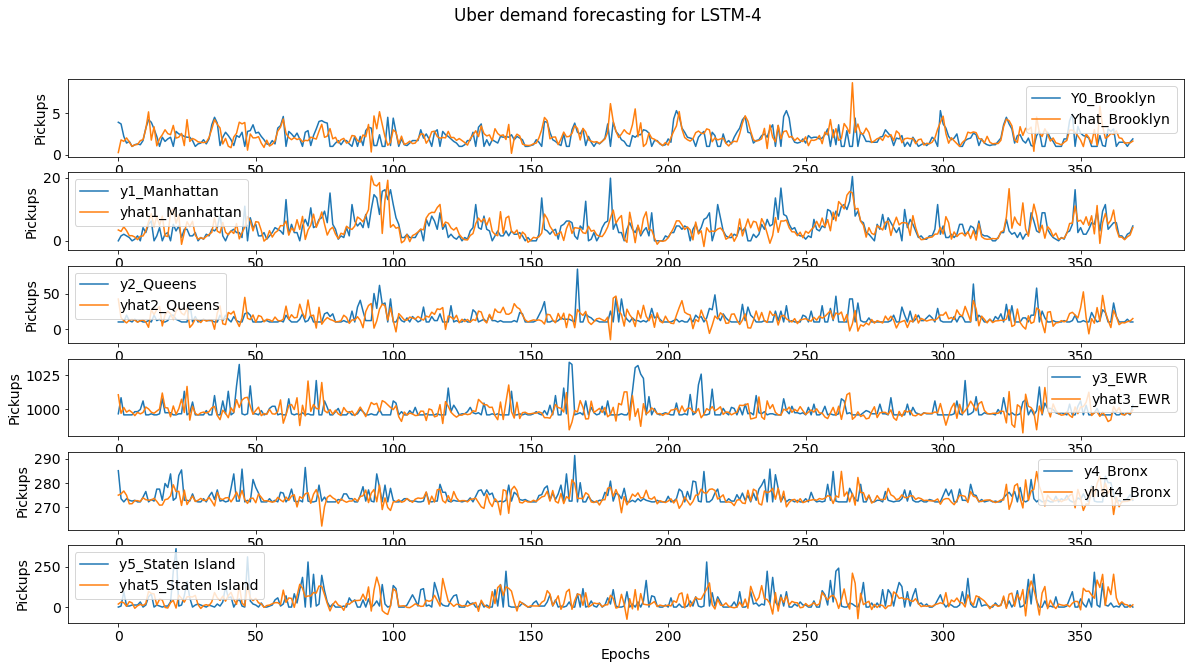

In [131]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1596:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), N))
inv_y = np.concatenate((test_y, test_X[:, 1596:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:]
print(inv_y.shape)
f3 = pyplot.figure(figsize=(20,10))
pyplot.subplot(6, 1, 1)
pyplot.plot(inv_y[:,0],label='Y0_Brooklyn')
pyplot.plot(inv_yhat[:,0],label='Yhat_Brooklyn')
pyplot.xlabel("Epochs")
pyplot.ylabel("Pickups")
pyplot.legend()

pyplot.subplot(6, 1, 2)
pyplot.plot(inv_y[:,1],label='y1_Manhattan')
pyplot.plot(inv_yhat[:,1],label='yhat1_Manhattan')
pyplot.xlabel("Epochs")
pyplot.ylabel("Pickups")
pyplot.legend()

pyplot.subplot(6, 1, 3)
pyplot.plot(inv_y[:,2],label='y2_Queens')
pyplot.plot(inv_yhat[:,2],label='yhat2_Queens')
pyplot.xlabel("Epochs")
pyplot.ylabel("Pickups")
pyplot.legend()

pyplot.subplot(6, 1, 4)
pyplot.plot(inv_y[:,3],label='y3_EWR')
pyplot.plot(inv_yhat[:,3],label='yhat3_EWR')
pyplot.xlabel("Epochs")
pyplot.ylabel("Pickups")
pyplot.legend()

pyplot.subplot(6, 1, 5)
pyplot.plot(inv_y[:,4],label='y4_Bronx')
pyplot.plot(inv_yhat[:,4],label='yhat4_Bronx')
pyplot.xlabel("Epochs")
pyplot.ylabel("Pickups")
pyplot.legend()

pyplot.subplot(6, 1, 6)
pyplot.plot(inv_y[:,5],label='y5_Staten Island')
pyplot.plot(inv_yhat[:,5],label='yhat5_Staten Island')
pyplot.xlabel("Epochs")
pyplot.ylabel("Pickups")
pyplot.legend()
f3.suptitle('Uber demand forecasting for LSTM-4')
pyplot.savefig('LSTM/LSTM-4_forecast.png')
pyplot.show()
now = datetime.datetime.now()


In [132]:
# calculate RMSE
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 25.836


In [133]:
abs(end-start)

103.5053699016571